In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv('../data/feature_engineered_data.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nFIFA version distribution:")
print(df['fifa_version'].value_counts().sort_index())
print(f"\nTarget distribution:")
print(df['big_potential'].value_counts())

Dataset shape: (41458, 29)

FIFA version distribution:
fifa_version
17.0    8889
18.0    8814
19.0    8777
20.0    8091
21.0    6887
Name: count, dtype: int64

Target distribution:
big_potential
0    31162
1    10296
Name: count, dtype: int64


In [3]:
# Define temporal splits
train_versions = [17.0, 18.0, 19.0,20.0]

test_version = 21.0


df_train = df[df['fifa_version'].isin(train_versions)]

df_test = df[df['fifa_version'] == test_version]

print(f"Train (FIFA 17-20): {len(df_train)} samples")

print(f"Test (FIFA 21): {len(df_test)} samples")
print(df_train["big_potential"].value_counts())

Train (FIFA 17-20): 34571 samples
Test (FIFA 21): 6887 samples
big_potential
0    25968
1     8603
Name: count, dtype: int64


In [4]:
feature_columns = [col for col in df.columns if col not in ['fifa_version', 'big_potential']]
target = 'big_potential'

print(f"Number of features: {len(feature_columns)}")
print(f"Features: {feature_columns}")

# Prepare datasets
X_train = df_train[feature_columns]
y_train = df_train[target]
print(X_train.shape)
X_test = df_test[feature_columns]
y_test = df_test[target]
print(X_test.shape)

Number of features: 27
Features: ['age', 'physic', 'mentality_aggression', 'mentality_interceptions', 'power_stamina', 'power_strength', 'defending_marking_awareness', 'power_jumping', 'defending_standing_tackle', 'defending_sliding_tackle', 'attacking_heading_accuracy', 'mentality_composure', 'movement_reactions', 'skill_long_passing', 'skill_dribbling', 'skill_fk_accuracy', 'skill_ball_control', 'attacking_crossing', 'power_shot_power', 'attacking_finishing', 'skill_curve', 'movement_balance', 'attacking_volleys', 'power_long_shots', 'mentality_vision', 'mentality_penalties', 'movement_agility']
(34571, 27)
(6887, 27)


In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [6]:
# Apply SMOTE oversampling to balance the training set
from imblearn.over_sampling import SMOTE

print("="*70)
print("APPLYING SMOTE OVERSAMPLING")
print("="*70)

# Check class distribution before SMOTE
print("\nClass distribution BEFORE SMOTE:")
print(f"No Big Potential (0): {(y_train == 0).sum()}")
print(f"Big Potential (1): {(y_train == 1).sum()}")
print(f"Ratio: {(y_train == 0).sum() / (y_train == 1).sum():.2f}:1")

# Apply SMOTE
smote = SMOTE(random_state=42, k_neighbors=5)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Check class distribution after SMOTE
print("\nClass distribution AFTER SMOTE:")
print(f"No Big Potential (0): {(y_train_resampled == 0).sum()}")
print(f"Big Potential (1): {(y_train_resampled == 1).sum()}")
print(f"Ratio: {(y_train_resampled == 0).sum() / (y_train_resampled == 1).sum():.2f}:1")
print(f"\nTotal samples after SMOTE: {len(X_train_resampled)}")
print(f"Original samples: {len(X_train_scaled)}")
print(f"New samples generated: {len(X_train_resampled) - len(X_train_scaled)}")


APPLYING SMOTE OVERSAMPLING

Class distribution BEFORE SMOTE:
No Big Potential (0): 25968
Big Potential (1): 8603
Ratio: 3.02:1

Class distribution AFTER SMOTE:
No Big Potential (0): 25968
Big Potential (1): 25968
Ratio: 1.00:1

Total samples after SMOTE: 51936
Original samples: 34571
New samples generated: 17365


In [7]:
# Train Logistic Regression model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix
)

print("="*70)
print("TRAINING LOGISTIC REGRESSION MODEL")
print("="*70)

# Initialize Logistic Regression with balanced class weights
lr_model = LogisticRegression(
    random_state=42,
    solver='lbfgs',  # Good for small datasets
    C=10,
    penalty='l2',  # Regularization strength (inverse of regularization)
    
)

print("\nTraining Logistic Regression on resampled data...")
lr_model.fit(X_train_resampled, y_train_resampled)
print("Training completed!")


TRAINING LOGISTIC REGRESSION MODEL

Training Logistic Regression on resampled data...
Training completed!


In [8]:
# Evaluate on training set (resampled)
print("="*70)
print("LOGISTIC REGRESSION - Training Set (Resampled) Metrics")
print("="*70)

y_train_pred = lr_model.predict(X_train_resampled)
y_train_proba = lr_model.predict_proba(X_train_resampled)[:, 1]

# Calculate metrics
accuracy = accuracy_score(y_train_resampled, y_train_pred)
precision = precision_score(y_train_resampled, y_train_pred)
recall = recall_score(y_train_resampled, y_train_pred)
f1 = f1_score(y_train_resampled, y_train_pred)
roc_auc = roc_auc_score(y_train_resampled, y_train_proba)

print(f"\nAccuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"ROC-AUC:   {roc_auc:.4f}")

print("\n" + "-"*70)
print("Classification Report:")
print("-"*70)
print(classification_report(y_train_resampled, y_train_pred, target_names=['No Big Potential', 'Big Potential']))

print("-"*70)
print("Confusion Matrix:")
print("-"*70)
cm = confusion_matrix(y_train_resampled, y_train_pred)
print(f"                  Predicted")
print(f"                  No BP    BP")
print(f"Actual No BP     {cm[0,0]:5d}  {cm[0,1]:5d}")
print(f"Actual BP        {cm[1,0]:5d}  {cm[1,1]:5d}")


LOGISTIC REGRESSION - Training Set (Resampled) Metrics

Accuracy:  0.6594
Precision: 0.6494
Recall:    0.6928
F1 Score:  0.6704
ROC-AUC:   0.7124

----------------------------------------------------------------------
Classification Report:
----------------------------------------------------------------------
                  precision    recall  f1-score   support

No Big Potential       0.67      0.63      0.65     25968
   Big Potential       0.65      0.69      0.67     25968

        accuracy                           0.66     51936
       macro avg       0.66      0.66      0.66     51936
    weighted avg       0.66      0.66      0.66     51936

----------------------------------------------------------------------
Confusion Matrix:
----------------------------------------------------------------------
                  Predicted
                  No BP    BP
Actual No BP     16254   9714
Actual BP         7977  17991


In [9]:
# Evaluate on original training set (before SMOTE)
print("="*70)
print("LOGISTIC REGRESSION - Original Training Set (Before SMOTE) Metrics")
print("="*70)

y_train_orig_pred = lr_model.predict(X_train_scaled)
y_train_orig_proba = lr_model.predict_proba(X_train_scaled)[:, 1]

# Calculate metrics
accuracy_orig = accuracy_score(y_train, y_train_orig_pred)
precision_orig = precision_score(y_train, y_train_orig_pred)
recall_orig = recall_score(y_train, y_train_orig_pred)
f1_orig = f1_score(y_train, y_train_orig_pred)
roc_auc_orig = roc_auc_score(y_train, y_train_orig_proba)

print(f"\nAccuracy:  {accuracy_orig:.4f}")
print(f"Precision: {precision_orig:.4f}")
print(f"Recall:    {recall_orig:.4f}")
print(f"F1 Score:  {f1_orig:.4f}")
print(f"ROC-AUC:   {roc_auc_orig:.4f}")

print("\n" + "-"*70)
print("Classification Report:")
print("-"*70)
print(classification_report(y_train, y_train_orig_pred, target_names=['No Big Potential', 'Big Potential']))

print("-"*70)
print("Confusion Matrix:")
print("-"*70)
cm_orig = confusion_matrix(y_train, y_train_orig_pred)
print(f"                  Predicted")
print(f"                  No BP    BP")
print(f"Actual No BP     {cm_orig[0,0]:5d}  {cm_orig[0,1]:5d}")
print(f"Actual BP        {cm_orig[1,0]:5d}  {cm_orig[1,1]:5d}")


LOGISTIC REGRESSION - Original Training Set (Before SMOTE) Metrics

Accuracy:  0.6389
Precision: 0.3751
Recall:    0.6779
F1 Score:  0.4830
ROC-AUC:   0.7049

----------------------------------------------------------------------
Classification Report:
----------------------------------------------------------------------
                  precision    recall  f1-score   support

No Big Potential       0.85      0.63      0.72     25968
   Big Potential       0.38      0.68      0.48      8603

        accuracy                           0.64     34571
       macro avg       0.61      0.65      0.60     34571
    weighted avg       0.74      0.64      0.66     34571

----------------------------------------------------------------------
Confusion Matrix:
----------------------------------------------------------------------
                  Predicted
                  No BP    BP
Actual No BP     16254   9714
Actual BP         2771   5832


In [10]:
# Evaluate on test set
print("="*70)
print("LOGISTIC REGRESSION - Test Set (FIFA 21) Metrics")
print("="*70)

y_test_pred = lr_model.predict(X_test_scaled)
y_test_proba = lr_model.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics
accuracy_test = accuracy_score(y_test, y_test_pred)
precision_test = precision_score(y_test, y_test_pred)
recall_test = recall_score(y_test, y_test_pred)
f1_test = f1_score(y_test, y_test_pred)
roc_auc_test = roc_auc_score(y_test, y_test_proba)

print(f"\nAccuracy:  {accuracy_test:.4f}")
print(f"Precision: {precision_test:.4f}")
print(f"Recall:    {recall_test:.4f}")
print(f"F1 Score:  {f1_test:.4f}")
print(f"ROC-AUC:   {roc_auc_test:.4f}")

print("\n" + "-"*70)
print("Classification Report:")
print("-"*70)
print(classification_report(y_test, y_test_pred, target_names=['No Big Potential', 'Big Potential']))

print("-"*70)
print("Confusion Matrix:")
print("-"*70)
cm_test = confusion_matrix(y_test, y_test_pred)
print(f"                  Predicted")
print(f"                  No BP    BP")
print(f"Actual No BP     {cm_test[0,0]:5d}  {cm_test[0,1]:5d}")
print(f"Actual BP        {cm_test[1,0]:5d}  {cm_test[1,1]:5d}")


LOGISTIC REGRESSION - Test Set (FIFA 21) Metrics

Accuracy:  0.6361
Precision: 0.3695
Recall:    0.6799
F1 Score:  0.4788
ROC-AUC:   0.6983

----------------------------------------------------------------------
Classification Report:
----------------------------------------------------------------------
                  precision    recall  f1-score   support

No Big Potential       0.86      0.62      0.72      5194
   Big Potential       0.37      0.68      0.48      1693

        accuracy                           0.64      6887
       macro avg       0.61      0.65      0.60      6887
    weighted avg       0.74      0.64      0.66      6887

----------------------------------------------------------------------
Confusion Matrix:
----------------------------------------------------------------------
                  Predicted
                  No BP    BP
Actual No BP      3230   1964
Actual BP          542   1151


In [11]:
# Summary comparison
print("="*70)
print("METRICS SUMMARY COMPARISON")
print("="*70)

print(f"\n{'Metric':<15} {'Resampled Train':<18} {'Original Train':<18} {'Test Set':<15}")
print("-" * 70)
print(f"{'Accuracy':<15} {accuracy:<18.4f} {accuracy_orig:<18.4f} {accuracy_test:<15.4f}")
print(f"{'Precision':<15} {precision:<18.4f} {precision_orig:<18.4f} {precision_test:<15.4f}")
print(f"{'Recall':<15} {recall:<18.4f} {recall_orig:<18.4f} {recall_test:<15.4f}")
print(f"{'F1 Score':<15} {f1:<18.4f} {f1_orig:<18.4f} {f1_test:<15.4f}")
print(f"{'ROC-AUC':<15} {roc_auc:<18.4f} {roc_auc_orig:<18.4f} {roc_auc_test:<15.4f}")


METRICS SUMMARY COMPARISON

Metric          Resampled Train    Original Train     Test Set       
----------------------------------------------------------------------
Accuracy        0.6594             0.6389             0.6361         
Precision       0.6494             0.3751             0.3695         
Recall          0.6928             0.6779             0.6799         
F1 Score        0.6704             0.4830             0.4788         
ROC-AUC         0.7124             0.7049             0.6983         


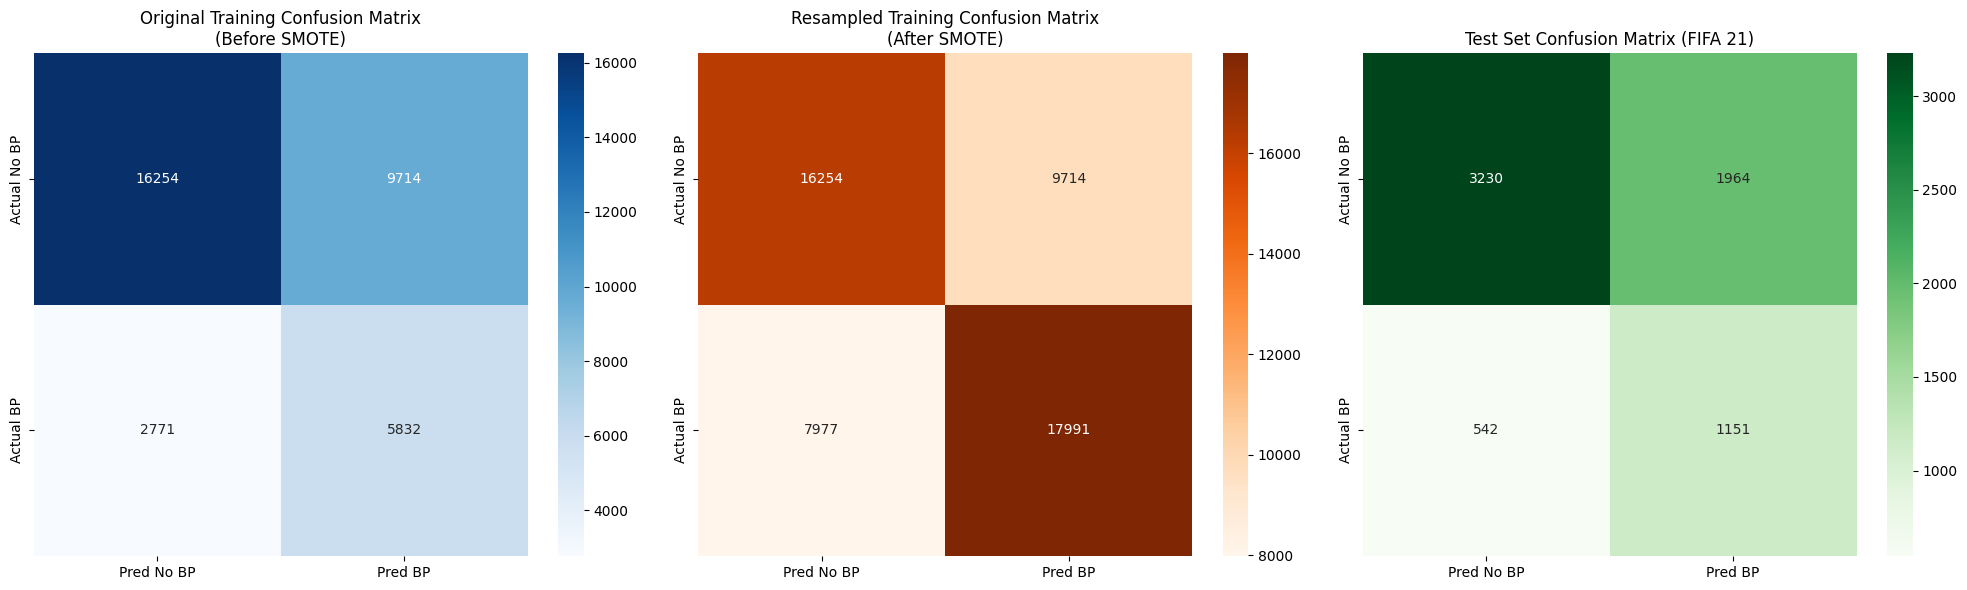

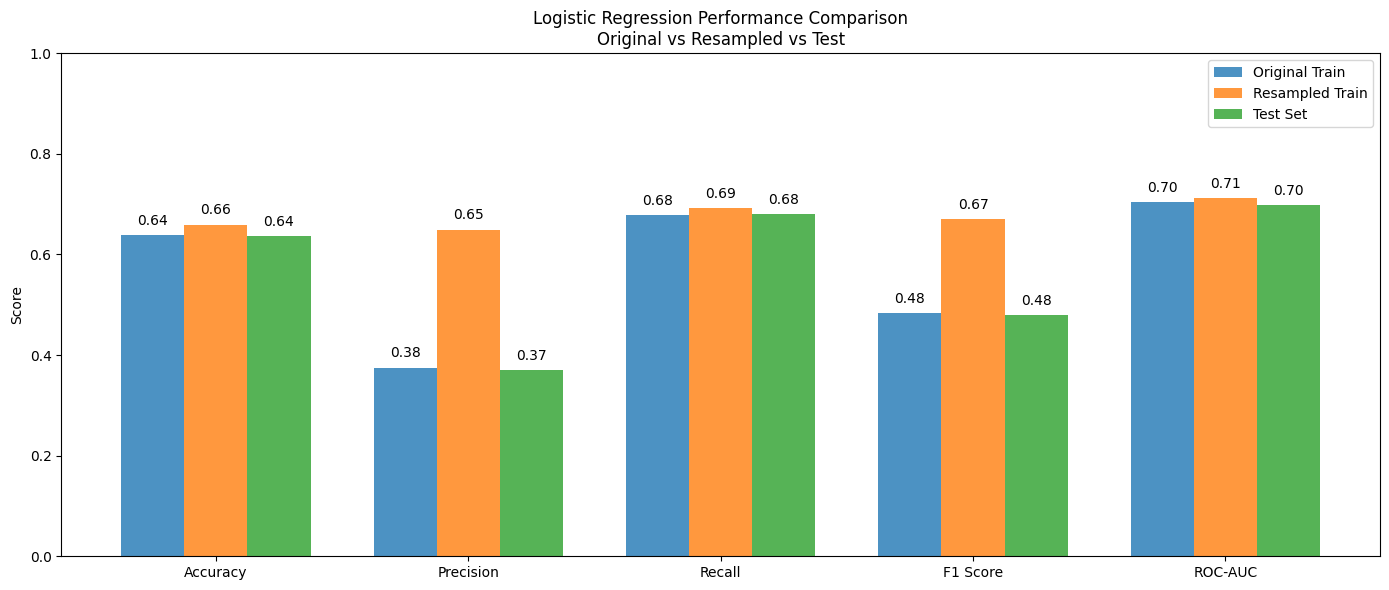

In [12]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# ============================================================
# CONFUSION MATRICES
# ============================================================

# Resampled Training Confusion Matrix
train_resampled_cm = np.array([
    [16254, 9714],
    [7977, 17991]
])

# Original Training Confusion Matrix
train_original_cm = np.array([
    [16254, 9714],
    [2771, 5832]
])

# Test Set Confusion Matrix
test_cm = np.array([
    [3230, 1964],
    [542, 1151]
])

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# --------------------
# Original Training CM
# --------------------
sns.heatmap(train_original_cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred No BP", "Pred BP"],
            yticklabels=["Actual No BP", "Actual BP"],
            ax=axes[0])
axes[0].set_title("Original Training Confusion Matrix\n(Before SMOTE)")

# --------------------
# Resampled Training CM
# --------------------
sns.heatmap(train_resampled_cm, annot=True, fmt="d", cmap="Oranges",
            xticklabels=["Pred No BP", "Pred BP"],
            yticklabels=["Actual No BP", "Actual BP"],
            ax=axes[1])
axes[1].set_title("Resampled Training Confusion Matrix\n(After SMOTE)")

# --------------------
# Test Set CM
# --------------------
sns.heatmap(test_cm, annot=True, fmt="d", cmap="Greens",
            xticklabels=["Pred No BP", "Pred BP"],
            yticklabels=["Actual No BP", "Actual BP"],
            ax=axes[2])
axes[2].set_title("Test Set Confusion Matrix (FIFA 21)")

plt.tight_layout()
plt.show()



# ============================================================
# METRICS BAR CHART
# ============================================================

metrics = ["Accuracy", "Precision", "Recall", "F1 Score", "ROC-AUC"]

# Training (resampled)
train_resampled_scores = [0.6594, 0.6494, 0.6928, 0.6704, 0.7124]

# Original training (before SMOTE)
train_original_scores = [0.6389, 0.3751, 0.6779, 0.4830, 0.7049]

# Test set
test_scores = [0.6361, 0.3695, 0.6799, 0.4788, 0.6983]

x = np.arange(len(metrics))
width = 0.25

plt.figure(figsize=(14, 6))

plt.bar(x - width, train_original_scores, width, label="Original Train", alpha=0.8)
plt.bar(x, train_resampled_scores, width, label="Resampled Train", alpha=0.8)
plt.bar(x + width, test_scores, width, label="Test Set", alpha=0.8)

plt.xticks(x, metrics)
plt.ylabel("Score")
plt.ylim(0, 1)
plt.title("Logistic Regression Performance Comparison\nOriginal vs Resampled vs Test")
plt.legend()

# Add values on bars
for i, v in enumerate(train_original_scores):
    plt.text(i - width, v + 0.02, f"{v:.2f}", ha="center")

for i, v in enumerate(train_resampled_scores):
    plt.text(i, v + 0.02, f"{v:.2f}", ha="center")

for i, v in enumerate(test_scores):
    plt.text(i + width, v + 0.02, f"{v:.2f}", ha="center")

plt.tight_layout()
plt.show()